# main function
## Kalman Filter

In [11]:
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr
from itertools import combinations,product
import talib

# Kalman filter class
class KalmanFilter(object):
    def __init__(self, a, b, c, x, p, q, r):
        self.a = a
        self.b = b
        self.c = c
        self.current_state_estimate = x
        self.current_prob_estimate = p
        self.q = q  # process covariace
        self.r = r  # measurement covariance
        self.predicted_state_estimate = 0
        self.observation = 0

    def current_state(self):
        return self.current_state_estimate

    def predicted_state(self):
        return self.predicted_state_estimate

    def observe(self):
        return self.observation

    def process(self, control_input, measurement):
        # prediction
        self.predicted_state_estimate = self.a * self.current_state_estimate + self.b * control_input
        predicted_prob_estimate = (self.a * self.current_prob_estimate) * self.a + self.q

        # observation
        self.observation = measurement - self.c * self.predicted_state_estimate
        observation_cov = self.c * predicted_prob_estimate * self.c + self.r

        # update
        kalman_gain = predicted_prob_estimate * self.c / float(observation_cov)
        self.current_state_estimate = self.predicted_state_estimate + kalman_gain * self.observation

        self.current_prob_estimate = (1 - kalman_gain * self.c) * predicted_prob_estimate


# kalman filter part
def kalman_filter(data,a=1,b=0,c=1,q=0.1,r=1,x=185,p=1):   # try to control r
#     x= data[0]
    filter = KalmanFilter(a, b, c, x, p, q, r)
    predictions = []
    estimate = []
    observe = []
    for d in data:
        filter.process(0, d)
        predictions.append(filter.current_state())
        estimate.append(filter.predicted_state())
        observe.append(filter.observe())

    predictions = [float(i) for i in predictions]
    estimate = [float(i) for i in estimate]
    observe = [float(i) for i in observe]

    # plt.figure(figsize=(12, 10))
    # plt.plot(data)
    # plt.plot(predictions)
    # plt.show();

    return predictions,estimate

In [2]:
def kf_strategy(data0, q):
    data = data0.copy()
    data['Return'] = data['Adj Close'].pct_change()
    prediction,estimate=kalman_filter(data['Adj Close'].values,q=q)
    data['estimate']=np.array(estimate)
    data['current_prediction']=np.array(prediction)

    data.loc[data.index[(data['estimate'] <= data['current_prediction'])],'position']= 1

    data.loc[data.index[(data['estimate'] > data['current_prediction'])],'position']= -1
    
    data['position'].fillna(0, inplace= True)
    data['daily_yield'] = data['position'].shift(1) * data['Return']
    
    annual_return = data['daily_yield'].mean() * 252
    annual_std = data['daily_yield'].std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_std

    data['cum_yield'] = (1 + data['daily_yield']).cumprod()

#     print(' Annual return: {:.6f} , Annual std: {:.6f} , Sharpe Ratio: {:.2f}'.
#           format(annual_return, annual_std, sharpe_ratio))

    return sharpe_ratio,annual_return,annual_std,data

## Benchmark

In [13]:
def Long_hold(stocks):
    stock = stocks.copy()
    stock['pct'] = stock['Adj Close'].pct_change(1).fillna(0)
    stock['position'] = 1
    
    stock['daily_yield'] = stock.pct * stock['position']
    stock['cum_yield'] = (1+stock['daily_yield']).cumprod()
    stock['cum_yield'].plot()
    return stock


def MA_test(stocks, wind1= 10, wind2= 20):
    stock = stocks.copy()
    stock['{}d'.format(wind1)]= np.round(stock['Adj Close'].rolling(window= wind1).mean(),3)
    stock['{}d'.format(wind2)]= np.round(stock['Adj Close'].rolling(window= wind2).mean(),3)
    stock['pct'] = stock['Adj Close'].pct_change(1).fillna(0)
    
    stock.loc[stock['{}d'.format(wind1)] >stock['{}d'.format(wind2)], 'position'] = 1
    stock['position'].fillna(-1, inplace=True)
    stock['position']=stock['position'].shift(periods=1) 
    stock.loc[~(stock['{}d'.format(wind2)]>0).values,'position']=0
    
    stock['daily_yield'] = stock.pct * stock['position']
    stock['cum_yield'] = (1+stock['daily_yield']).cumprod()
    stock['cum_yield'].plot()
    return stock

def MACD_test(stocks):
    stock = stocks.copy()
    signal = talib.MACD(stock['Adj Close'])[-1]
    stock['pct'] = stock['Adj Close'].pct_change(1).fillna(0)
    
    stock.loc[signal>0,'position']=1
#     stock['position'].fillna(-1, inplace=True)
    stock.loc[signal<0,'position']= -1
    stock['position']=stock['position'].shift(periods=1) 
#     stock.loc[~(signal>0),'position']=0
    
    stock['daily_yield'] = stock.pct * stock['position']
    stock['cum_yield'] = (1+stock['daily_yield']).cumprod()
    stock['cum_yield'].plot()
    return stock

## performance & graph

In [7]:
def performance_table(strategy_return):
    '''
    strategy_return contains three columns-- position, daily_yield, cum_yield
    '''
    Net_value= strategy_return.cum_yield[-1]
    
    Annualized_return= strategy_return['daily_yield'].mean()*250
    Annualized_vol = strategy_return['daily_yield'].std()*250**0.5
    
    Sharp = strategy_return['daily_yield'].mean()/strategy_return['daily_yield'].std()*250**0.5
    Draw_down= 1- strategy_return['cum_yield']/strategy_return['cum_yield'].cummax()
    Maxdrawdown = Draw_down.max()
    
    trade_total =strategy_return.loc[lambda x: x.position.diff(periods=-1)!=0,:][:-1].cum_yield.diff()
    trade_profit = trade_total[lambda x:x>0]
    trade_loss = trade_total[lambda x:x<=0]
    
    Trade_times = len(trade_total)-1
    Winning_rate = len(trade_profit)/Trade_times
    Pnl_ratio =trade_profit.sum()/abs(trade_loss.sum())
    
    symbol =['Net value','Annualized reutrn','Annualized volatility',\
            'Sharpe ratio','Maxdrawdown','Winning rate','Trading times','p&l ratio']
    ratios = {'ratio': [Net_value, Annualized_return, Annualized_vol,Sharp, \
            Maxdrawdown,  Winning_rate,Trade_times, Pnl_ratio]}
    
    table = pd.DataFrame( ratios, index=symbol )
    return table

In [14]:
def plot_price_position(data):
    data[['Adj Close', 'position']].plot(
        figsize=(10, 4), secondary_y=['position'])
    plt.show()
    return None
    
def plot_filter(data,Filter=0.2):
    data[['filter','cum_yield']].plot(
        figsize=(10, 4), secondary_y=['filter'])
#     plt.title('{} Kalman Filter training data \nsharpe ratio: {:.2f}'.format(s,sharpe_ratio))
    plt.axhline(y = Filter, color='r', linestyle='--')
    plt.show()
    return None
def plot_return(data):
    data.cum_yield.plot()
    plt.show()
    return None

# model 0

In [8]:
start = pd.to_datetime('2014-1-1')
end = pd.to_datetime('2019-1-1')
Ticker = 'SPY'

df = web.DataReader(Ticker, 'yahoo', start=start, end=end)

## Benchmark

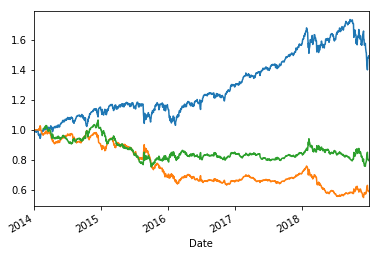

In [15]:
benchmark0 = long_hold(df)
benchmark1 =   MA_test(df)
benchmark2 = MACD_test(df)

In [18]:
performance_table(benchmark0),performance_table(benchmark1),performance_table(benchmark2)

/Users/zhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


(                          ratio
 Net value              1.494148
 Annualized reutrn      0.088392
 Annualized volatility  0.131372
 Sharpe ratio           0.672835
 Maxdrawdown            0.193489
 Winning rate          -0.000000
 Trading times         -1.000000
 p&l ratio                   NaN,                            ratio
 Net value               0.588492
 Annualized reutrn      -0.096740
 Annualized volatility   0.130528
 Sharpe ratio           -0.741142
 Maxdrawdown             0.466757
 Winning rate            0.308824
 Trading times          68.000000
 p&l ratio               0.482422,                             ratio
 Net value                0.795342
 Annualized reutrn       -0.038107
 Annualized volatility    0.131407
 Sharpe ratio            -0.289989
 Maxdrawdown              0.294157
 Winning rate             0.204545
 Trading times          132.000000
 p&l ratio                0.729159)

##  model 0 , setting q and r = 1

In [19]:
performance_table( kf_strategy(df, 1)[-1])

,ratio
Net value,1.100848
Annualized reutrn,0.027735
Annualized volatility,0.131532
Sharpe ratio,0.210858
Maxdrawdown,0.292415
Winning rate,0.334101
Trading times,434.000000
p&l ratio,1.068293


# model 1 : optimization process

In [21]:
def kf_optimize_q(data):
    Q = np.arange(0,5,step=0.01)
    SR = [kf_strategy(data,q)[0] for q in Q]
    ymax = max(SR)
    xmax = Q[SR.index(ymax)]
    
    fig, ax = plt.subplots(1,1)
    ax.plot(Q, SR)
    text = "Q={:.3f}, Sharpe Ratio={:.3f}".format(xmax, ymax)
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax),
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
    plt.xlabel('Process Covariace(Q) ')
    plt.ylabel('Sharpe Ratio')
    ax.set_xlim(0, 5)
    plt.show()
    return xmax

In [ ]:
size = int(len(df.index) * 0.6)
train, test = df.iloc[:size, :].copy() , df.iloc[size:, :].copy()

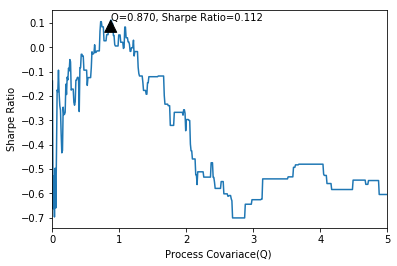

In [28]:
q_optimal = kf_optimize_q(train)

In [30]:
performance_table(kf_strategy(test, 1)[-1])

,ratio
Net value,1.116315
Annualized reutrn,0.063003
Annualized volatility,0.129067
Sharpe ratio,0.488140
Maxdrawdown,0.174946
Winning rate,0.315789
Trading times,171.000000
p&l ratio,1.230516


In [29]:
performance_table(kf_strategy(test, q_optimal)[-1])

,ratio
Net value,1.128366
Annualized reutrn,0.068339
Annualized volatility,0.129056
Sharpe ratio,0.529533
Maxdrawdown,0.175355
Winning rate,0.319527
Trading times,169.000000
p&l ratio,1.258655


# model 2 : filter

In [41]:
def rankc():
    df1 = df[['Adj Close']].copy()
    df1.loc[:,'Return'] = df1['Adj Close'].pct_change()
    df1.loc[:, 'MA5'] = df1.loc[:, 'Adj Close'].rolling(5).mean()
    df1.loc[:, 'MA10'] = df1.loc[:, 'Adj Close'].rolling(10).mean()
    df1.loc[:, 'MA20'] = df1.loc[:, 'Adj Close'].rolling(20).mean()
    df1.loc[:, 'MA30'] = df1.loc[:, 'Adj Close'].rolling(30).mean()
    rank = df1.iloc[:, -4:].rank(axis=1).values
    
    trading_order=[4, 3, 2, 1]
    idx = [ i for i in range(29,len(df1.index))]
    
    df1.loc[df1.index[idx], 'Rank Coefficient'] =np.array([spearmanr(trading_order, rank[i])[0] for i in idx])
    df1['filter'] = abs(df1['Rank Coefficient'].rolling(30).mean())
    
    return df1['filter'] 

def kf_rankc_strategy(data0, q, Filter=0.2):
    data = data0.copy()
    data['Return'] = data['Adj Close'].pct_change()
    prediction,estimate=kalman_filter(data['Adj Close'].values,q=q)
    data['estimate']=np.array(estimate)
    data['current_prediction']=np.array(prediction)
    
    start_date = data.index[0]
    
    data['filter'] = rankc().loc[start_date:]

    data.loc[data.index[(data['estimate'] <= data['current_prediction']) & 
                                (np.abs(data['filter']) > Filter)],'position']= 1

    data.loc[data.index[(data['estimate'] > data['current_prediction']) & 
                                (np.abs(data['filter']) > Filter)],'position']= -1
    data['position'].fillna(0, inplace= True)
    
    data['daily_yield'] = data['position'].shift(1) * data['Return']

    annual_return = data['daily_yield'].mean() * 252
    annual_std = data['daily_yield'].std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_std
    data['cum_yield'] = (1 + data['daily_yield']).cumprod()


    print(' Annual return: {:.3f} , Annual std: {:.3f} , Sharpe Ratio: {:.2f}'.
          format(annual_return, annual_std, sharpe_ratio))

    return sharpe_ratio,annual_return,annual_std,data

 Annual return: 0.116362 , Annual std: 0.114071 , Sharpe Ratio: 1.02


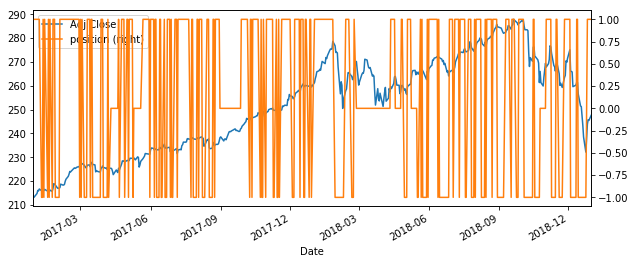

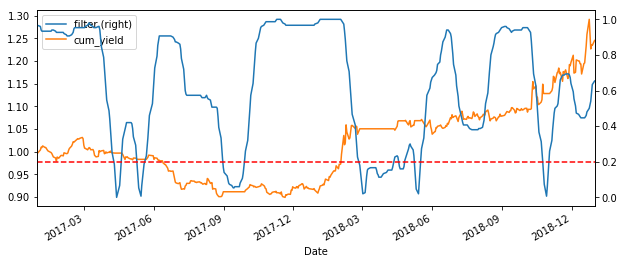

In [33]:
model_2 = kf_rankc_strategy(test,q_optimal, Filter= 0.2)[-1]
plot_price_position(model_2)
plot_filter(model_2)

In [42]:
#Filter selection
Q=np.arange(0.1, 0.5, step=0.05)
for f in Q:
    print('filter {:.2}'.format(f))
    kf_rankc_strategy(test, q=0.9, Filter = f)
    print('\n')

filter 0.1
 Annual return: 0.098 , Annual std: 0.127 , Sharpe Ratio: 0.77


filter 0.15
 Annual return: 0.110 , Annual std: 0.119 , Sharpe Ratio: 0.92


filter 0.2
 Annual return: 0.116 , Annual std: 0.114 , Sharpe Ratio: 1.02


filter 0.25
 Annual return: 0.103 , Annual std: 0.112 , Sharpe Ratio: 0.92


filter 0.3
 Annual return: 0.095 , Annual std: 0.109 , Sharpe Ratio: 0.87


filter 0.35
 Annual return: 0.094 , Annual std: 0.108 , Sharpe Ratio: 0.86


filter 0.4
 Annual return: 0.074 , Annual std: 0.106 , Sharpe Ratio: 0.70


filter 0.45
 Annual return: 0.070 , Annual std: 0.103 , Sharpe Ratio: 0.68




#### pyecharts needed to run the following code

In [165]:
from pyecharts import Line, Scatter, Overlap, Style
day = pd.to_datetime(panel_data_0['Adj Close'].index, unit='d').strftime('%Y-%m-%d ')

title_style=Style(title_text_size= 22, subtitle_text_size = 13, subtitle_color='#111',\
            title_pos='center')

line = Line(title='Long & Hold VS MA VS MACD',
             **title_style.init_style)

line.add('LH',day, list(np.round(benchmark0['cum_yield'].values,4)),\
#           mark_point=["max", "min"], 
         mark_point_symbol="diamond", mark_point_symbolsize=1,
          is_datazoom_show=True, tooltip_trigger='axis',mark_point_textcolor="black",\
         yaxis_min='dataMin',yaxis_max='dataMax',
         legend_top="1%", legend_pos="90%")
line.add('MA',day, list(np.round(benchmark1['cum_yield'].values,4)),\
#           mark_point=["max", "min"], 
         mark_point_symbol="diamond", mark_point_symbolsize=1,
          is_datazoom_show=True, tooltip_trigger='axis',mark_point_textcolor="black",
         yaxis_min='dataMin',yaxis_max='dataMax',
         legend_top="1%", legend_pos="90%")
line.add('MACD',day, list(np.round(benchmark2['cum_yield'].values,4)),\
#           mark_point=["max", "min"],
         mark_point_symbol="diamond", mark_point_symbolsize=1,
          is_datazoom_show=True, tooltip_trigger='axis',mark_point_textcolor="black",
         yaxis_min='dataMin',yaxis_max='dataMax',
         legend_top="1%", legend_pos="90%")

# line4 = Line()
# line4.add('drawdown', day, list(Draw_down),  \
#           is_datazoom_show=True, tooltip_trigger='axis',mark_point_textcolor="black")

# overlap2 = Overlap(width=1000, height=400)
# overlap2.add(line3)
# overlap2.add(line4, yaxis_index=1, is_add_yaxis=True)

line

In [40]:
def graph_price_position(strategy_return):
    '''
    strategy_return contains four columns--Adj Close, position, daily_yield, cum_yield
    '''
    day = pd.to_datetime(strategy_return['Adj Close'].index, unit='d').strftime('%Y-%m-%d ')
    Draw_down= 1- strategy_return['cum_yield']/strategy_return['cum_yield'].cummax()
    
    line1 = Line("Underlying asset price and position")
    line1.add('price',day, list(np.round(strategy_return['Adj Close'].values,1)),\
    mark_point=["max", "min"], mark_point_symbol="diamond", mark_point_symbolsize=30,
              is_datazoom_show=True, tooltip_trigger='axis',mark_point_textcolor="black",\
             yaxis_min='dataMin',yaxis_max='dataMax')
    
    line2 = Line(" position")
    line2.add('position', day, list(strategy_return['position']),  \
              is_datazoom_show=True, tooltip_trigger='axis',mark_point_textcolor="black")
    
    overlap1 = Overlap()
    overlap1.add(line1)
    overlap1.add(line2, yaxis_index=1, is_add_yaxis=True)
    
    return overlap1



In [80]:
def graph_return_dd(strategy_return):
    '''
    strategy_return contains three columns-- position, daily_yield, cum_yield
    '''
    day = pd.to_datetime(strategy_return['Adj Close'].index, unit='d').strftime('%Y-%m-%d ')
    Draw_down= 1- strategy_return['cum_yield']/strategy_return['cum_yield'].cummax()
    
    strategy_performance=performance_table(strategy_return)
    ###
    mm = list(strategy_performance.T.columns[[0,1,3,4,5,6]])
    rr = list(strategy_performance.T.iloc[0,[0,1,3,4,5,6]])
    hh = ['{}: {:.2f}%  '.format(mm[i],rr[i]*100) if i ==1\
          else '{}: {:.0f}  '.format(mm[i],rr[i]) if i ==5 \
          else '{}: {:.2f}  '.format(mm[i],rr[i])for i in range(len(mm)) ]
    s=''.join(hh)
    ###

    title_style=Style(title_text_size= 22, subtitle_text_size = 13, subtitle_color='#111',\
                title_pos='center')
    
    line3 = Line(title='Strategy Return', subtitle='{}'.format(s),
                 **title_style.init_style)
    
    line3.add('net return',day, list(np.round(strategy_return['cum_yield'].values,4)),
              mark_point=["max", "min"], mark_point_symbol="diamond", mark_point_symbolsize=1,
              is_datazoom_show=True, tooltip_trigger='axis',mark_point_textcolor="black",
             yaxis_min='dataMin',yaxis_max='dataMax',
             legend_top="1%", legend_pos="85%")
    
    line4 = Line()
    line4.add('drawdown', day, list(Draw_down),  \
              is_datazoom_show=True, tooltip_trigger='axis',mark_point_textcolor="black")
    
    overlap2 = Overlap(width=1000, height=400)
    overlap2.add(line3)
    overlap2.add(line4, yaxis_index=1, is_add_yaxis=True)
    
    return overlap2